# 将矩阵数值从0 23.6 45.3 55.1 65.7 均匀映射到0.03-1，其中0对应0.03, 65.7对应1，结果为约是：[0.030,0.378,0.699,0.844,1.000]

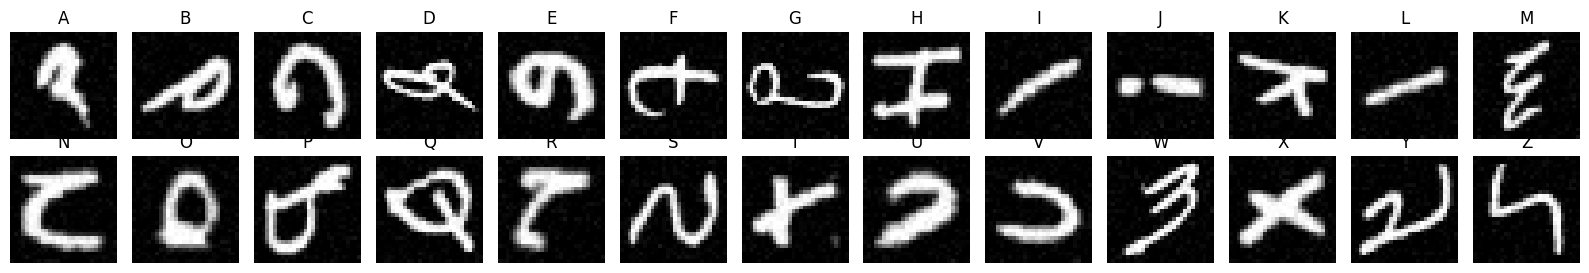

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms, datasets

# 1. 在 Tensor 空间暗化 + 高斯噪声
def add_gaussian_noise(tensor, mean=0.0, std=0.03):
    noise = torch.randn_like(tensor) * std + mean
    return (tensor + noise).clamp(0.0, 1.0)

def tensor_darken_and_noise(tensor, dark_factor=0.4, noise_std=0.03):
    t = tensor * dark_factor
    if noise_std > 0:
        t = add_gaussian_noise(t, std=noise_std)
    return t

# 2. 定义 transform：先 ToTensor，再暗化+噪声
darken_noise_transform = transforms.Compose([
    transforms.ToTensor(),  # PIL->[0,1]
    transforms.Lambda(lambda t: tensor_darken_and_noise(
        t,
        dark_factor=1,  # 保留 40% 原始亮度
        noise_std=0.03    # 噪声标准差 0.03
    )),
])

# 3. 加载原始 EMNIST 测试集（letters split），不做任何 transform
raw_test = datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=True,
    transform=None,               # 保留为 PIL.Image
    target_transform=lambda y: y-1  # 标签范围 0–25
)

# 4. 可视化 A–Z
fig, axs = plt.subplots(2, 13, figsize=(16, 3))
# fig.suptitle("EMNIST Letters Darkened + Noisy", fontsize=16)

for letter in range(26):
    # 找到第一个属于该字母(label=letter)的索引
    indices = np.where(raw_test.targets.numpy() == (letter+1))[0]
    idx = indices[0]
    pil_img, _ = raw_test[idx]             # PIL.Image
    tensor_img = darken_noise_transform(pil_img)  # FloatTensor [0,1]

    ax = axs[letter // 13, letter % 13]
    ax.imshow(tensor_img.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(chr(letter + ord('A')))
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('az_65.png')
plt.show()


In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision
from torchvision import transforms

# 1. 在 Tensor 空间暗化 + 可选高斯噪声
def add_gaussian_noise(tensor, mean=0.0, std=0.0):
    noise = torch.randn_like(tensor) * std + mean
    return (tensor + noise).clamp(0.0, 1.0)

def tensor_darken_and_noise(tensor, dark_factor=0.9, noise_std=0.01):
    """
    tensor: FloatTensor, shape (C,H,W), values in [0,1]
    dark_factor: 暗化比例，<1 变暗
    noise_std: 噪声标准差
    """
    t = tensor * dark_factor
    if noise_std > 0:
        t = add_gaussian_noise(t, std=noise_std)
    return t

# 2. 定义 transform
train_transform = transforms.Compose([
    transforms.ToTensor(),  # PIL -> [0,1] Tensor
    transforms.Lambda(lambda t: tensor_darken_and_noise(
        t,
        dark_factor=0.03,   # 保留 90% 亮度
        noise_std=0.03     # 加入少量噪声
    )),
])
test_transform = transforms.ToTensor()  # 测试集保持原样

# 3. 加载数据集
train_data = torchvision.datasets.EMNIST(
    root='./data',
    split='letters',
    train=True,
    download=True,
    transform=train_transform,
    target_transform=lambda y: y - 1  # 标签从 1-26 映射到 0-25
)
test_data = torchvision.datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=False,
    transform=test_transform,
    target_transform=lambda y: y - 1
)

train_loader = Data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = Data.DataLoader(test_data,  batch_size=2000, shuffle=False)

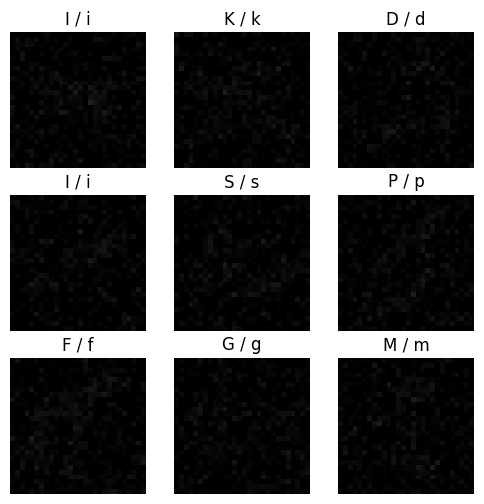

In [136]:
def get_mapping(num):
    # letters 切分: 0->A/a, …, 25->Z/z
    return chr(num + 65) + " / " + chr(num + 97)

figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    idx = torch.randint(len(train_data), (1,)).item()
    img, label = train_data[idx]  # img: FloatTensor(1,28,28)
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(get_mapping(label))
    ax.axis('off')
    ax.imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()

In [137]:
# 4. 三层 MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# 5. 训练 & 测试
for epoch in range(1):
    model.train()
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x, b_y = b_x.to(device), b_y.to(device)
        logits   = model(b_x)
        loss     = criterion(logits, b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_x, test_y = next(iter(test_loader))
                test_x, test_y = test_x.to(device), test_y.to(device)
                preds = model(test_x).argmax(dim=1)
                acc   = (preds == test_y).float().mean().item()
            print(f'Epoch {epoch} | step {step} | loss {loss.item():.4f} | test acc {acc:.2f}')
            model.train()

Epoch 0 | step 0 | loss 3.2400 | test acc 0.00
Epoch 0 | step 100 | loss 3.2441 | test acc 0.19
Epoch 0 | step 200 | loss 3.0454 | test acc 0.01
Epoch 0 | step 300 | loss 2.6088 | test acc 0.09
Epoch 0 | step 400 | loss 2.8455 | test acc 0.05
Epoch 0 | step 500 | loss 2.5663 | test acc 0.06
Epoch 0 | step 600 | loss 2.4246 | test acc 0.03
Epoch 0 | step 700 | loss 2.2660 | test acc 0.03
Epoch 0 | step 800 | loss 2.1984 | test acc 0.05
Epoch 0 | step 900 | loss 2.4214 | test acc 0.09
Epoch 0 | step 1000 | loss 2.3576 | test acc 0.05
Epoch 0 | step 1100 | loss 2.2263 | test acc 0.17
Epoch 0 | step 1200 | loss 2.0767 | test acc 0.10
Epoch 0 | step 1300 | loss 2.2049 | test acc 0.16
Epoch 0 | step 1400 | loss 2.1586 | test acc 0.13
Epoch 0 | step 1500 | loss 1.9785 | test acc 0.19
Epoch 0 | step 1600 | loss 1.9867 | test acc 0.22
Epoch 0 | step 1700 | loss 1.9951 | test acc 0.20
Epoch 0 | step 1800 | loss 2.2458 | test acc 0.23
Epoch 0 | step 1900 | loss 1.7721 | test acc 0.23
Epoch 0 | st

# 将上述代码生成的准确率和step关系绘制成图片，result文件夹下保存loss和acc

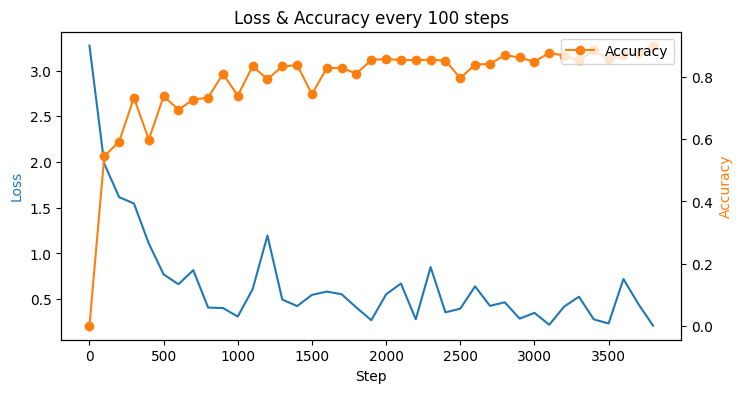

Saved CSV to result_dark/loss_acc_65.csv
Saved plot to result_dark/loss_acc_65_plot.png


In [7]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# 确保 result 目录存在
os.makedirs('result_dark', exist_ok=True)

# ——（1） 数据准备，和之前一致 —— #
def add_gaussian_noise(tensor, mean=0.0, std=0.0):
    noise = torch.randn_like(tensor) * std + mean
    return (tensor + noise).clamp(0.0, 1.0)

def tensor_darken_and_noise(tensor, dark_factor=0.03, noise_std=0.03):
    t = tensor * dark_factor
    if noise_std > 0:
        t = add_gaussian_noise(t, std=noise_std)
    return t

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: tensor_darken_and_noise(t, dark_factor=1, noise_std=0.03)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: tensor_darken_and_noise(t, dark_factor=1, noise_std=0.03)),
])

train_ds = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=True, download=True,
    transform=train_transform, target_transform=lambda y: y-1
)
test_ds = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=False, download=False,
    transform=test_transform, target_transform=lambda y: y-1
)

train_loader = Data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = Data.DataLoader(test_ds, batch_size=2048, shuffle=False)

# ——（2） 定义模型 —— #
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(28*28, 256)
        self.relu1   = nn.ReLU()
        self.fc2     = nn.Linear(256, 128)
        self.relu2   = nn.ReLU()
        self.fc3     = nn.Linear(128, 26)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# ——（3） 训练并每 100 步记录一次 loss/acc —— #
record_steps, record_losses, record_accs = [], [], []
step = 0

for epoch in range(1):
    model.train()
    for b_x, b_y in train_loader:
        b_x, b_y = b_x.to(device), b_y.to(device)
        logits   = model(b_x)
        loss     = criterion(logits, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 每 100 步记录
        if step % 100 == 0:
            # 记录训练损失
            record_steps.append(step)
            record_losses.append(loss.item())

            # 评估测试集准确率
            model.eval()
            with torch.no_grad():
                tx, ty = next(iter(test_loader))
                tx, ty = tx.to(device), ty.to(device)
                preds   = model(tx).argmax(dim=1)
                acc     = (preds == ty).float().mean().item()
            record_accs.append(acc)
            model.train()

        step += 1

# ——（4） 保存 CSV —— #
csv_path = 'result_dark/loss_acc_65.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['step', 'loss', 'acc'])
    for s, l, a in zip(record_steps, record_losses, record_accs):
        writer.writerow([s, l, a])

# ——（5） 绘图并保存 —— #
plt.figure(figsize=(8,4))
plt.plot(record_steps, record_losses, label='Loss', color='tab:blue')
plt.xlabel('Step')
plt.ylabel('Loss', color='tab:blue')
plt.twinx()
plt.plot(record_steps, record_accs, label='Accuracy', color='tab:orange', marker='o')
plt.ylabel('Accuracy', color='tab:orange')
plt.title('Loss & Accuracy every 100 steps')
plt.legend(loc='upper right')
plot_path = 'result_dark/loss_acc_65_plot.png'
plt.savefig(plot_path, bbox_inches='tight')
plt.show()

print(f"Saved CSV to {csv_path}")
print(f"Saved plot to {plot_path}")


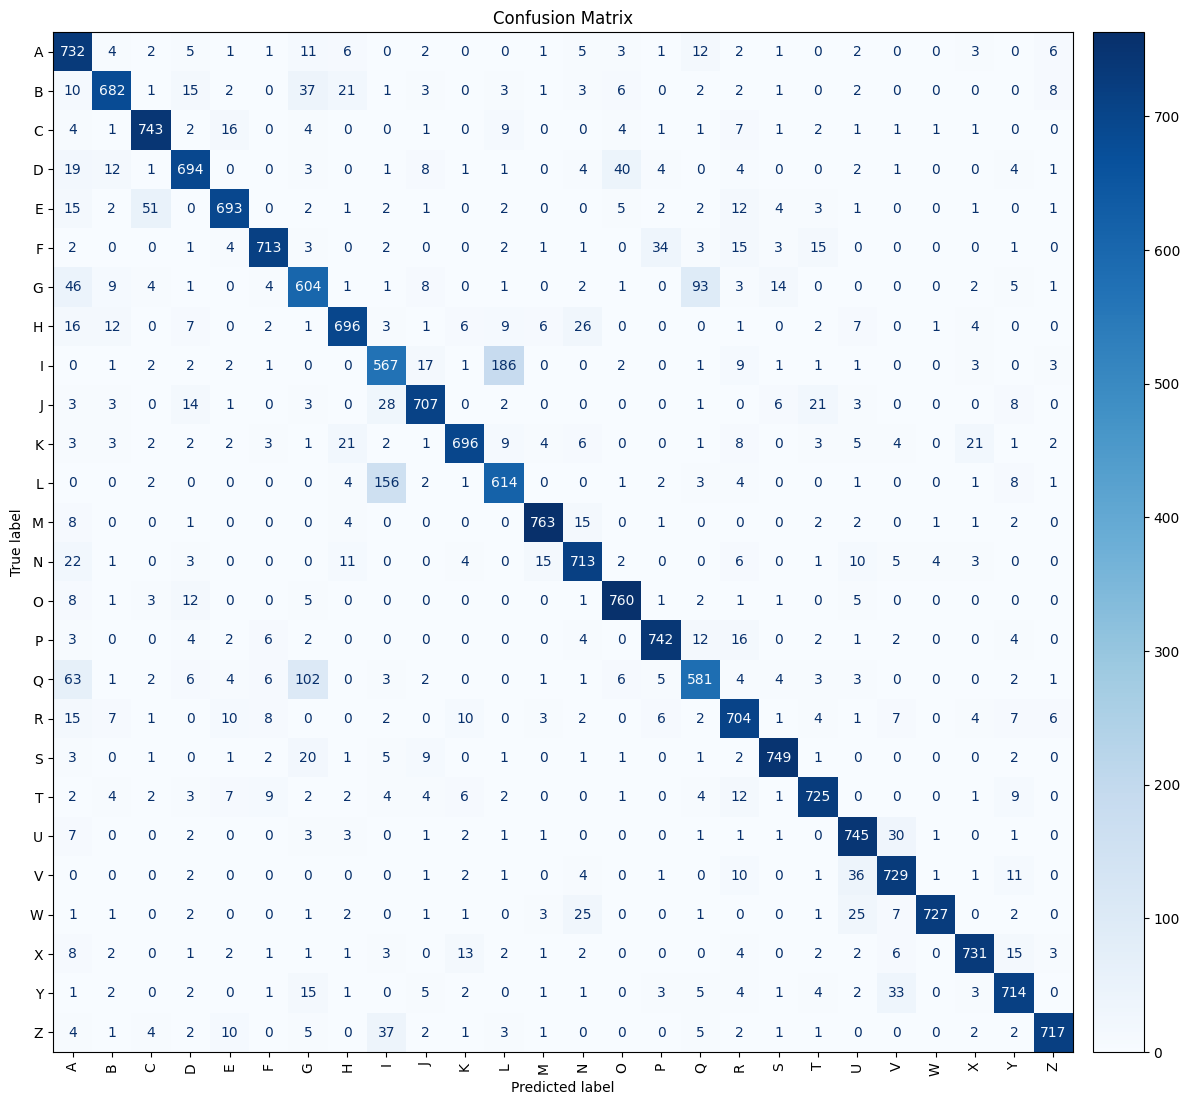

In [25]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.axes_grid1 import make_axes_locatable

# —— 1. 收集预测与真实标签 —— #
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())
all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# —— 2. 计算混淆矩阵 & 保存 CSV —— #
cm = confusion_matrix(all_labels, all_preds)
csv_raw = 'result_dark/confusion_matrix_raw.csv'
with open(csv_raw, 'w', newline='') as f:
    writer = csv.writer(f)
    header = [''] + [chr(i + 65) for i in range(26)]
    writer.writerow(header)
    for i, row in enumerate(cm):
        writer.writerow([chr(i + 65)] + row.tolist())

# —— 3. 绘制混淆矩阵 + 手动等高 colorbar —— #
labels = [chr(i + 65) for i in range(26)]
disp   = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Confusion Matrix")
ax.set_xticklabels(labels, rotation=90)

# 用 make_axes_locatable 创建一个与 ax 等高的 cax
divider = make_axes_locatable(ax)
cax     = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(disp.im_, cax=cax)

plt.tight_layout()
fig.savefig('result_dark/confusion_matrix_raw.png', dpi=150)
plt.show()


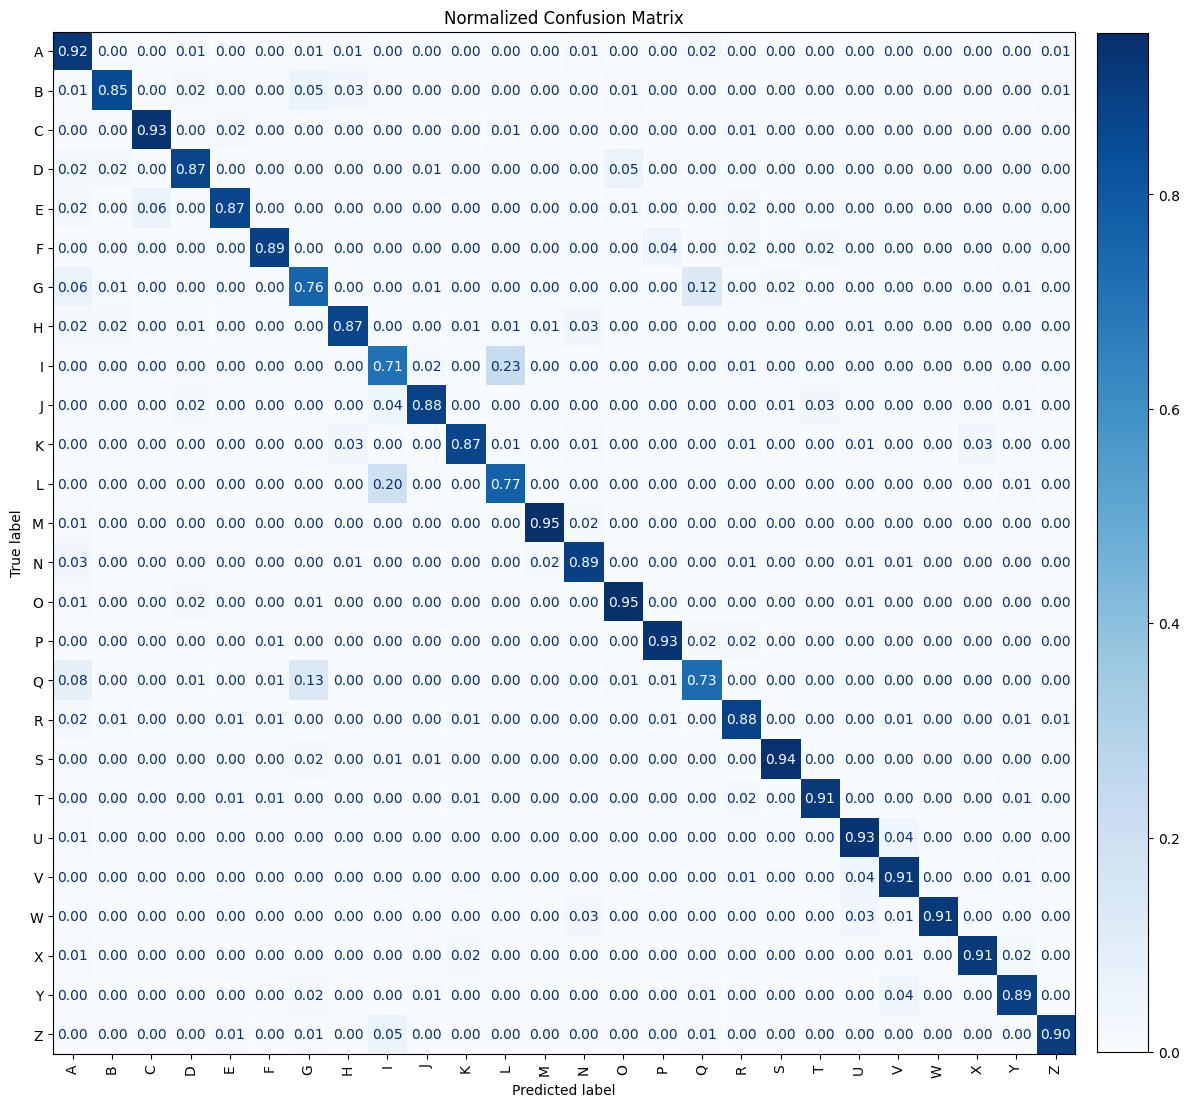

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1. 读取并归一化
df = pd.read_csv('result_dark/confusion_matrix_raw.csv', index_col=0)
cm = df.values
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.round(cm_norm, 2)

labels = df.index.tolist()

# 2. 绘制矩阵，不自动绘 colorbar
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp.plot(
    ax=ax,
    cmap=plt.cm.Blues,
    colorbar=False,       # 先不画 colorbar
    values_format='.2f'
)

# 3. 手动加一个和主图等高的 colorbar
# disp.im_ 是最后绘制的 AxesImage 对象
cbar = fig.colorbar(disp.im_, ax=ax, fraction=0.0465, pad=0.02)
# fraction 控制 colorbar 宽度，pad 控制主图和 colorbar 间距

# 4. 美化
ax.set_xticklabels(labels, rotation=90)
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
fig.savefig('result_dark/confusion_matrix_normalized.png', dpi=150)
plt.show()


In [128]:
# 4. 定义 CNN 模型（输出改为 26 类）
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32*7*7, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        return self.out(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# 5. 训练 & 测试
for epoch in range(1):
    model.train()
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x, b_y = b_x.to(device), b_y.to(device)
        logits   = model(b_x)
        loss     = criterion(logits, b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_x, test_y = next(iter(test_loader))
                test_x, test_y = test_x.to(device), test_y.to(device)
                preds = model(test_x).argmax(dim=1)
                acc   = (preds == test_y).float().mean().item()
            print(f'Epoch {epoch} | step {step} | loss {loss.item():.4f} | test acc {acc:.2f}')
            model.train()

Epoch 0 | step 0 | loss 3.2716 | test acc 0.07
Epoch 0 | step 100 | loss 3.2632 | test acc 0.00
Epoch 0 | step 200 | loss 3.2616 | test acc 0.00
Epoch 0 | step 300 | loss 3.2592 | test acc 0.00
Epoch 0 | step 400 | loss 3.2549 | test acc 0.00
Epoch 0 | step 500 | loss 3.2588 | test acc 0.00
Epoch 0 | step 600 | loss 3.2589 | test acc 0.00
Epoch 0 | step 700 | loss 3.2525 | test acc 0.00
Epoch 0 | step 800 | loss 3.2595 | test acc 0.00
Epoch 0 | step 900 | loss 3.2607 | test acc 0.00
Epoch 0 | step 1000 | loss 3.2598 | test acc 0.00
Epoch 0 | step 1100 | loss 3.2550 | test acc 0.00
Epoch 0 | step 1200 | loss 3.2599 | test acc 0.00
Epoch 0 | step 1300 | loss 3.2619 | test acc 0.00
Epoch 0 | step 1400 | loss 3.2576 | test acc 0.00
Epoch 0 | step 1500 | loss 3.2609 | test acc 0.00
Epoch 0 | step 1600 | loss 3.2533 | test acc 0.00
Epoch 0 | step 1700 | loss 3.2538 | test acc 0.00
Epoch 0 | step 1800 | loss 3.2621 | test acc 0.00
Epoch 0 | step 1900 | loss 3.2593 | test acc 0.00
Epoch 0 | st

KeyboardInterrupt: 